In [1]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
from lib.funcs import *
from lib.mapping import *

In [2]:
recorte_maior = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_maior.shp')
recorte_menor = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_menor.shp')
limite_mun = gpd.read_file('./data/BASES/limite_municipio/limite_municipio.shp')
lotes_empreendimentos = gpd.read_file('./data/BASES/empreendimento/empreendimento.shp')
populacao_bairros = gpd.read_file('./data/POPULACAO/bairros.shp')
populacao_setores = gpd.read_file('./data/POPULACAO/setores_recorte.shp')
limite_mun = gpd.read_file("./data/BASES/limite_municipio/limite_municipio.shp")
bairros_recorte_menor = gpd.read_file("./data/BASES/bairros/bairros_recorte_menor.shp")
bairros_recorte_maior = gpd.read_file("./data/BASES/bairros/bairros_recorte_maior.shp")
avenidas = gpd.read_file('./data/BASES/AVENIDAS/avenidas.shp')


lotes_empreendimentos = lotes_empreendimentos.to_crs(epsg=3857)
bairros_recorte_maior = bairros_recorte_maior.to_crs(epsg=3857)
bairros_recorte_menor = bairros_recorte_menor.to_crs(epsg=3857)

In [3]:
bairros_recorte_maior = bairros_recorte_maior.merge(populacao_bairros, on='NM_BAIRRO', suffixes=('_y', ''))
bairros_recorte_maior.drop(bairros_recorte_maior.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [4]:
lotes_empreendimentos = lotes_empreendimentos.reindex([1, 0, 2])
lotes_empreendimentos['Name'] = lotes_empreendimentos.index+1
lotes_empreendimentos['coords'] = lotes_empreendimentos['geometry'].apply(lambda x: x.centroid.coords[:])
lotes_empreendimentos['coords'] = [coords[0] for coords in lotes_empreendimentos['coords']]

In [5]:
def plot_categorical(
    df,
    column,
    k,
    alpha,
    borders,
    avenidas,
    lotes_empreendimentos,
    bairros_recorte,
    x,
    y,
    output,
    annotation_pos_1,
    annotation_pos_2,
    annotation_pos_3,
    zoom,
    legend_title,
    scale_extension=1,
    factor_top=1,
    factor_right=1,
    factor_bottom=1,
    factor_left=1,
    legend_y=0.07,
    annotate_bairros=True,
    annotate_lotes=False,
    plot_avenidas=False,
):

    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams["figure.figsize"] = (15, 15)
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False
    plt.style.use("ggplot")
    plt.rcParams["figure.facecolor"] = "#ffffff"
    plt.rcParams["figure.edgecolor"] = "red"
    mpl.rcParams["legend.facecolor"] = "#ffffff"
    mpl.rcParams["figure.edgecolor"] = "black"
    mpl.rcParams["legend.loc"] = "lower center"

    fig = plt.figure(figsize=(15, 15))
    gs1 = gridspec.GridSpec(2, 1, height_ratios=[10, 0.5])
    gs1.update(wspace=0.01, hspace=0.01)
    ax = plt.subplot(gs1[0], projection=ccrs.epsg(3857))
    cax = plt.subplot(gs1[1])
    plt.subplots_adjust(wspace=0, hspace=0)
    ax.set_facecolor("none")
    # ax.set_axis_off()

    plot = df.plot(
        ax=ax,
        column=column,
        cmap="viridis_r",
        linewidth=1,
        scheme="quantiles",
        k=k,
        edgecolor="#FFFFFF",
        alpha=alpha,
        zorder=1,
    )

    crop(ax, factor_top, factor_right, factor_bottom, factor_left)

    cmap = mpl.cm.viridis.reversed()
    divider = make_axes_locatable(ax)

    bins = get_bins(df, column, k=k)

    norm = mpl.colors.BoundaryNorm(bins, cmap.N)

    for i, border in enumerate(borders):
        border_plot = border.plot(
            ax=ax,
            facecolor="none",
            edgecolor="black",
            linewidth=(0.6 + (i + 1 / 2)),
            linestyle="--",
        )

    if plot_avenidas:
        avenidas.plot(
            ax=ax, facecolor="none", edgecolor="tab:red", linewidth=1.5, alpha=0.7
        )
        ax.text(-3880153.607, -794580.444, s="Avenida Pres. Epitácio Pessoa", alpha=0.9)
        ax.text(
            -3881553.607, -795300.444, s="Avenida Beira Rio", rotation=-25, alpha=0.9
        )

    ctx.add_basemap(
        ax,
        source=ctx.providers.Stamen.TonerBackground,
        zoom=zoom,
        alpha=0.2,
        attribution="",
        zorder=0,
    )

    legend_elements = []
    legend_elements = [
        Line2D(
            [0],
            [0],
            color="#2BBDCC",
            lw=2,
            label="Novos Empreendimentos",
            linestyle="--",
        ),
        Line2D([0], [0], color="#000000", lw=2, label="Área Foco", linestyle="--"),
    ]

    # Create the figure
    ax.legend(handles=legend_elements, loc="lower left")

    scale = scale_bar(ax, ccrs.epsg(3857), scale_extension)

    plt.annotate(
        "Fonte: IBGE - Censo 2010",
        (0, 0),
        annotation_pos_1,
        xycoords="axes fraction",
        textcoords="offset points",
        va="center",
    )
    plt.annotate(
        "Base Cartográfica por Stamen Design",
        (0, 0),
        annotation_pos_2,
        xycoords="axes fraction",
        textcoords="offset points",
        va="center",
    )

    # cax = divider.append_axes("bottom", size="5%", pad=0.05)
    # plt.tight_layout(pad=0)

    cb = mpl.colorbar.ColorbarBase(
        ax=cax,
        cmap=cmap,
        norm=norm,
        spacing="uniform",
        orientation="horizontal",
        extend="neither",
        ticks=bins,
        drawedges=True,
        alpha=alpha,
    )
    cb.outline.set_edgecolor("#ffffff")
    cb.dividers.set_linewidth(3)

    bairros_recorte.plot(
        ax=ax, facecolor="none", edgecolor="black", linewidth=0.6, alpha=0.6
    )

    if annotate_bairros:
        anotate_bairros(ax, plt, bairros_recorte, x, y)

    pos1 = cax.get_position()  # get the original position
    pos2 = [pos1.x0 + 0.004, pos1.y0 + legend_y, pos1.width, pos1.height]
    cax.set_position(pos2)  # set a new position
    cax.tick_params(colors="none")
    plt.setp(cax.get_xticklabels(), color="black")

    plt.annotate(
        legend_title,
        (0, 0),
        annotation_pos_3,
        xycoords="axes fraction",
        textcoords="offset points",
        va="center",
    )

    empreendimentos_plot = lotes_empreendimentos.plot(
        ax=ax, facecolor="none", edgecolor="tab:cyan", linewidth=(2.5), linestyle="--"
    )

    if annotate_lotes:
        anotate_lotes(ax, plt, lotes_empreendimentos)
    # operator_t.MULTIPLY.patch_artist(plot)
    # operator_t.SOURCE.patch_artist(empreendimentos_plot)

    plt.savefig("OUTPUT/" + output + ".pdf", bbox_inches='tight')
    plt.savefig("OUTPUT/" + output + ".png", bbox_inches='tight')

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f4e8c75c900> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


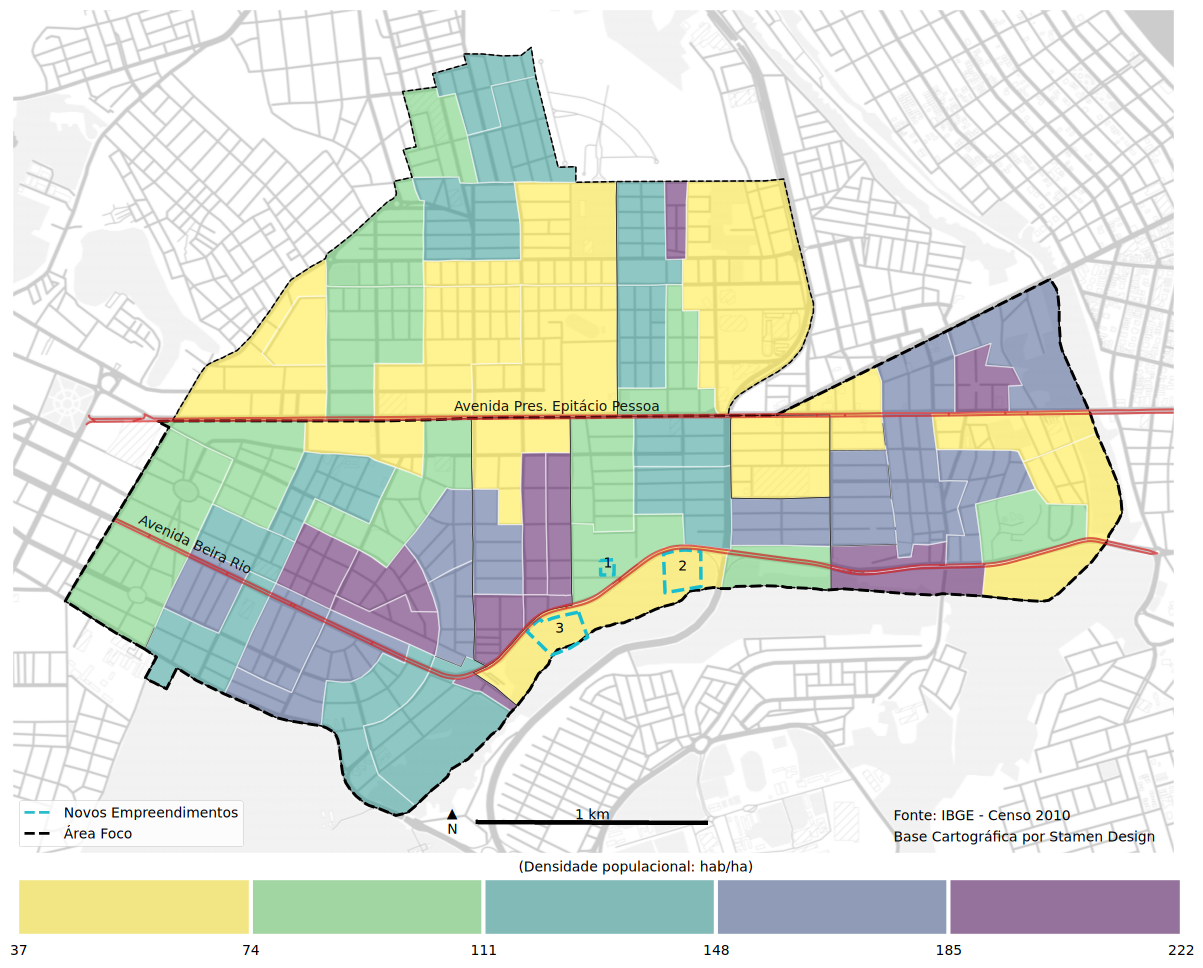

In [6]:
borders = [recorte_maior, recorte_menor]
plot_categorical(populacao_setores, 
                 'densidade',
                 5,
                 0.5,
                 [recorte_maior, recorte_menor],
                 avenidas,
                 lotes_empreendimentos,
                 bairros_recorte_maior,
                 .075,
                 .175,
                 'POPULACAO/densidade_populacional_recorte', 
                 (630, 85), 
                 (630, 70), 
                 (360, 48),
                 16, 
                 '(Densidade populacional: hab/ha)',
                 legend_y = 0.07,
                 scale_extension=1,
                 factor_left=1,
                 factor_right=1,
                 factor_bottom=1,
                 factor_top=1,
                 annotate_bairros=False,
                 annotate_lotes=True,
                 plot_avenidas=True)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f4e83c7aa90> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


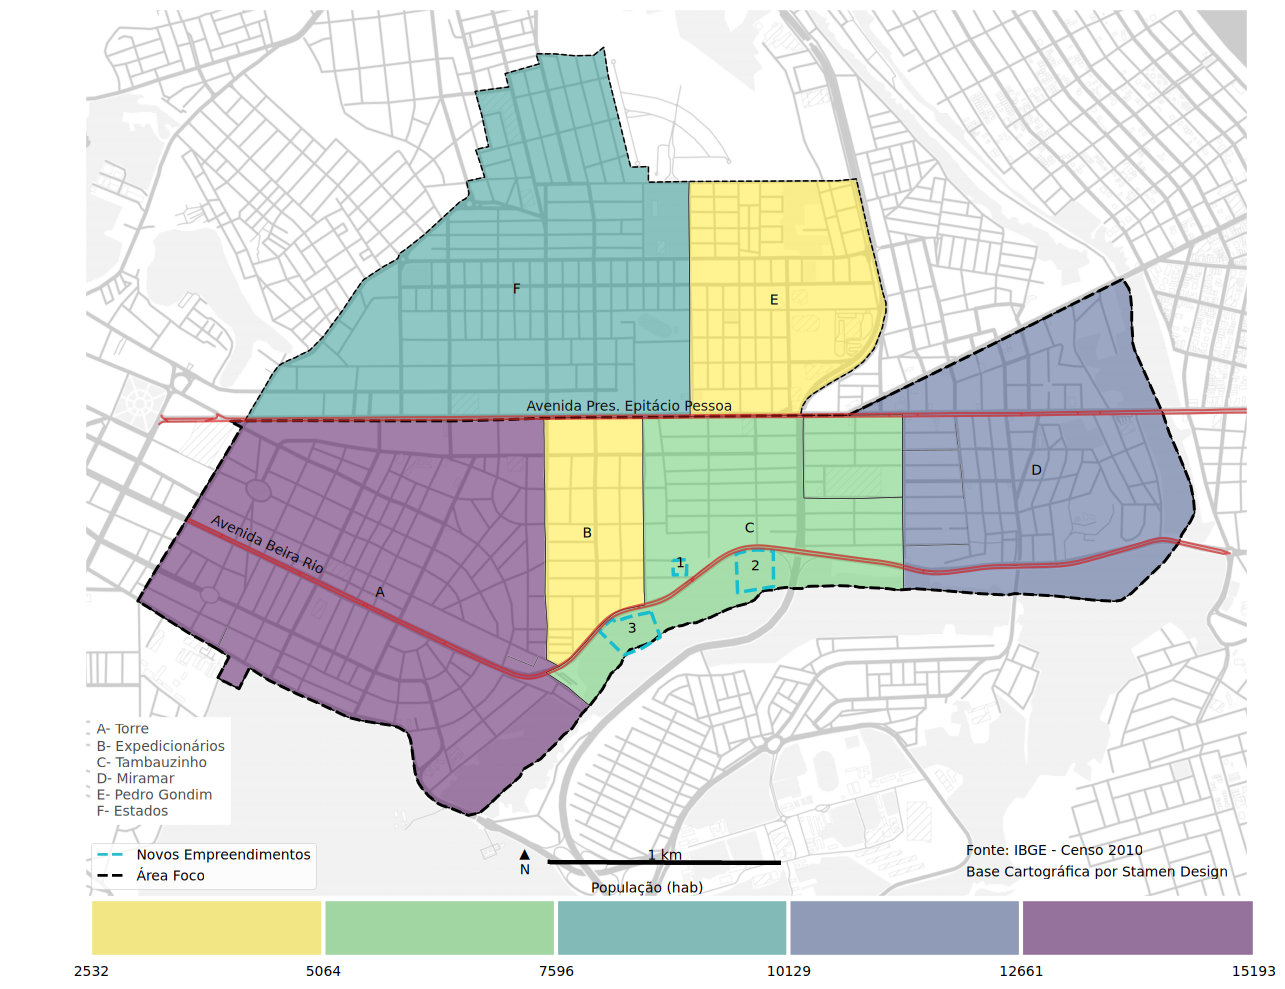

In [7]:
plot_categorical(bairros_recorte_maior, 
                 'MORADORES',
                 5,
                 0.5,
                 [recorte_maior, recorte_menor],
                 avenidas,
                 lotes_empreendimentos,
                 bairros_recorte_maior,
                 .075,
                 .175,
                 'POPULACAO/populacao_recorte', 
                 (630, 75), 
                 (630, 60), 
                 (360, 48),
                 16, 
                 'População (hab)',
                 legend_y = 0.07,
                 scale_extension=1,
                 factor_left=1,
                 factor_right=1,
                 factor_bottom=1.1,
                 factor_top=1,
                 annotate_lotes=True,
                 plot_avenidas=True)

In [ ]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor], 
                 avenidas,
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .075,
                 .175,
                 'POPULACAO/densidade_populacional_centro', 
                 (630, 85), 
                 (630, 70), 
                 (360, 48),
                 16, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=2,
                 legend_y = 0.03,
                 factor_left=0.5,
                 factor_right=0.7,
                 factor_bottom=0.05,
                 annotate_lotes=False,
                 factor_top=0.7)

In [ ]:
plot_categorical(populacao_bairros, 
                 'MORADORES',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 avenidas,
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .075,
                 .175,
                 'POPULACAO/populacao_centro', 
                 (630, 95), 
                 (630, 80), 
                 (360, 48),
                 14, 
                 'População (hab)', 
                 scale_extension=2,
                 legend_y = 0.03,
                 factor_left=0.5,
                 factor_right=0.7,
                 factor_bottom=0.05,
                 factor_top=0.7)

In [ ]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 avenidas,
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .83,
                 .85,
                 'POPULACAO/densidade_populacional_cidade', 
                 (600, 65), 
                 (600, 50), 
                 (325, 48),
                 13, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=5,
                 legend_y = 0,
                 factor_left=1.45,
                 factor_right=1.45,
                 factor_bottom=1.07,
                 factor_top=1)

In [ ]:
plot_categorical(populacao_bairros, 
                 'MORADORES',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 avenidas,
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .83,
                 .85,
                 'POPULACAO/populacao_cidade', 
                 (600, 65), 
                 (600, 50), 
                 (360, 48),
                 13, 
                 'População (hab)', 
                 scale_extension=5,
                 legend_y = 0,
                 factor_left=1.45,
                 factor_right=1.45,
                 factor_bottom=1.07,
                 factor_top=1)